# Regressão Linear com um conjunto de dados real

Este Notebook usa um conjunto de dados real baseado nos dados do censo de 1990 da Califórnia para prever os preços das casas.

In [16]:
#@title Importando módulos relevantes
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [5]:
#@title Carregando o arquivo .csv em um DataFrame do pandas

# Import the dataset.
training_df = pd.read_csv(filepath_or_buffer="https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")

# Scale the label.
training_df["median_house_value"] /= 1000.0

# Print the first rows of the pandas DataFrame.
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5


## Examinando o conjunto de dados

Uma grande parte da maioria dos projetos de aprendizado de máquina consiste em conhecer seus dados. A API do pandas fornece uma função `describe` que gera as seguintes estatísticas sobre cada coluna no DataFrame:

* `count`, que é o número de linhas nessa coluna. Idealmente, `count` contém o mesmo valor para cada coluna.

* `mean` e `std`, que contêm a média e o desvio padrão dos valores em cada coluna.

* `min` e `max`, que contêm os valores mais baixos e mais altos em cada coluna.

* `25%`, `50%`, `75%`, que contêm vários [quantis](https://developers.google.com/machine-learning/glossary/#quantile).

In [6]:
#@title Obtendo estatísticas sobre o conjunto de dados.
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


* O valor máximo (max) de diversas colunas parece muito
alto em comparação com os outros quantis. Por exemplo,
o exemplo da coluna total_rooms. Dado o quantil
valores (25%, 50% e 75%), você pode esperar o
valor máximo de total_rooms será aproximadamente 5.000 ou possivelmente 10.000. No entanto, o valor máximo
é na verdade 37.937.

* Ao ver anomalias em uma coluna, tenha mais cuidado
sobre como usar essa coluna como um recurso. Dito isto,
anomalias em recursos potenciais às vezes refletem
anomalias no rótulo, que podem tornar a coluna
seja (ou pareça ser) um recurso poderoso.
* Além disso, você pode ser capaz de representar (pré-processar) dados brutos
para transformar colunas em recursos úteis.

In [7]:
#@title Definindo as funções que constroem e treinam um modelo
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  model.add(tf.keras.layers.Dense(units=1,
                                  input_shape=(1,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error.
  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, df, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs.
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # To track the progression of training, we're going to take a snapshot
  # of the model's root mean squared error at each epoch.
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

print("Defined the build_model and train_model functions.")

Defined the build_model and train_model functions.


## Funções de plotagem

As seguintes funções [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) criam os seguintes gráficos:

* um gráfico de dispersão do recurso versus o rótulo e uma linha mostrando a saída do modelo treinado
* uma curva de perda

In [8]:
#@title Defindo as funções de plotagem
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against 200 random training examples."""

  # Label the axes.
  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = training_df.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = random_examples[feature].max()
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


Epoch 1/30
567/567 [==============================] - 1s 1ms/step - loss: 487047.3750 - root_mean_squared_error: 697.8878
Epoch 2/30
567/567 [==============================] - 1s 1ms/step - loss: 27945.9473 - root_mean_squared_error: 167.1704
Epoch 3/30
567/567 [==============================] - 1s 1ms/step - loss: 27141.1426 - root_mean_squared_error: 164.7457
Epoch 4/30
567/567 [==============================] - 1s 1ms/step - loss: 26409.3848 - root_mean_squared_error: 162.5096
Epoch 5/30
567/567 [==============================] - 1s 1ms/step - loss: 25969.5762 - root_mean_squared_error: 161.1508
Epoch 6/30
567/567 [==============================] - 1s 1ms/step - loss: 25133.7246 - root_mean_squared_error: 158.5362
Epoch 7/30
567/567 [==============================] - 1s 2ms/step - loss: 24537.2637 - root_mean_squared_error: 156.6438
Epoch 8/30
567/567 [==============================] - 1s 2ms/step - loss: 23989.9141 - root_mean_squared_error: 154.8868
Epoch 9/30
567/567 [===========

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


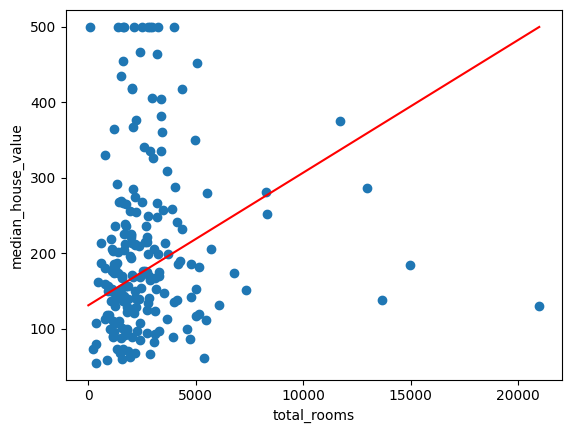

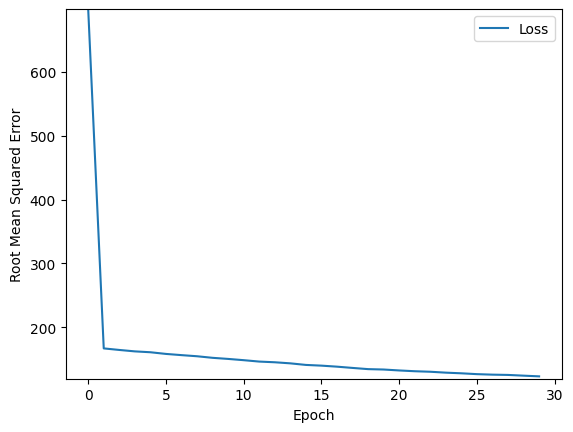

In [9]:
#@title Invocando as funções do modelo

# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 30
batch_size = 30

# Specify the feature and the label.
my_feature = "total_rooms"  # the total number of rooms on a specific city block.
my_label="median_house_value" # the median value of a house on a specific city block.
# That is, you're going to create a model that predicts house value based
# solely on total_rooms.

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,
                                         my_feature, my_label,
                                         epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

In [10]:
#@title Usando o modelo para fazer previsões
def predict_house_values(n, feature, label):
  """Predict house values based on a feature."""

  batch = training_df[feature][10000:10000 + n]
  predicted_values = my_model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("  value   value          value")
  print("          in thousand$   in thousand$")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (training_df[feature][10000 + i],
                                   training_df[label][10000 + i],
                                   predicted_values[i][0] ))

In [11]:
#@title Invocando a função de previsão de casa em 10 exemplos:
predict_house_values(10, my_feature, my_label)

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 1960     53             166
 3400     92             191
 3677     69             196
 2202     62             170
 2403     80             173
 5652    295             230
 3318    500             189
 2552    342             176
 1364    118             155
 3468    128             192


Epoch 1/3
142/142 [==============================] - 1s 2ms/step - loss: 3683459.7500 - root_mean_squared_error: 1919.2341
Epoch 2/3
142/142 [==============================] - 0s 1ms/step - loss: 2868442.5000 - root_mean_squared_error: 1693.6477
Epoch 3/3
142/142 [==============================] - 0s 1ms/step - loss: 3605764.0000 - root_mean_squared_error: 1898.8849


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


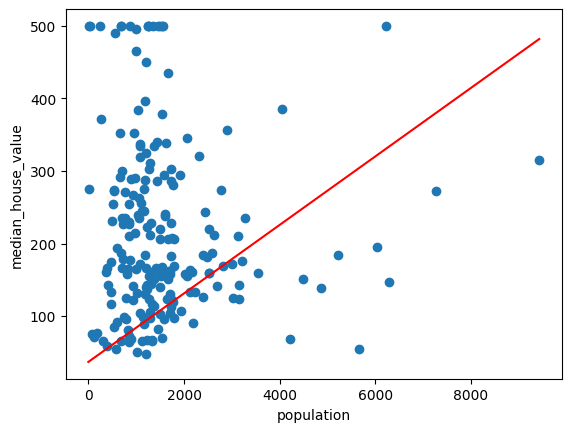

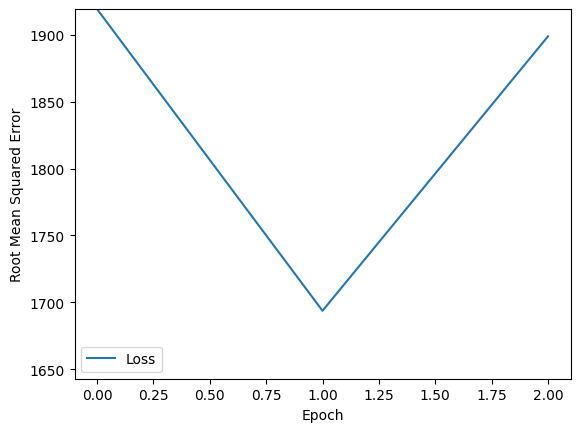

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 1286     53              98
 1867     92             125
 2191     69             140
 1052     62              86
 1647     80             115
 2312    295             146
 1604    500             113
 1066    342              87
  338    118              53
 1604    128             113
 1200    187              93
  292     80              51
 2014    112             132
 1817     95             123
 1328     69             100


In [12]:
#@title Experimentando um recurso diferente
my_feature = "population"

# Experiment with the hyperparameters.
learning_rate = 2
epochs = 3
batch_size = 120

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,
                                         my_feature, my_label,
                                         epochs, batch_size)
plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(15, my_feature, my_label)

Epoch 1/24
567/567 [==============================] - 2s 2ms/step - loss: 39572.2812 - root_mean_squared_error: 198.9278
Epoch 2/24
567/567 [==============================] - 1s 2ms/step - loss: 19253.2148 - root_mean_squared_error: 138.7560
Epoch 3/24
567/567 [==============================] - 1s 1ms/step - loss: 15042.0801 - root_mean_squared_error: 122.6462
Epoch 4/24
567/567 [==============================] - 1s 1ms/step - loss: 14758.8564 - root_mean_squared_error: 121.4860
Epoch 5/24
567/567 [==============================] - 1s 1ms/step - loss: 14696.1064 - root_mean_squared_error: 121.2275
Epoch 6/24
567/567 [==============================] - 1s 2ms/step - loss: 14482.6846 - root_mean_squared_error: 120.3440
Epoch 7/24
567/567 [==============================] - 1s 2ms/step - loss: 14278.6621 - root_mean_squared_error: 119.4934
Epoch 8/24
567/567 [==============================] - 1s 2ms/step - loss: 14120.2285 - root_mean_squared_error: 118.8286
Epoch 9/24
567/567 [============

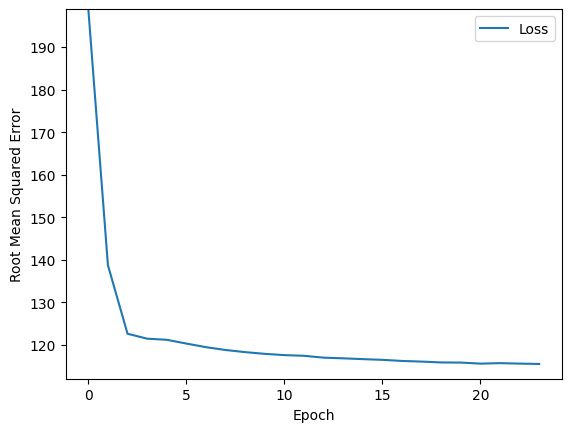

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
    2     53             189
    2     92             200
    2     69             195
    2     62             211
    1     80             186
    2    295             224
    2    500             210
    2    342             222
    4    118             285
    2    128             213
    2    187             223
    3     80             233
    2    112             224
    2     95             218
    2     69             210


In [13]:
#@title Definindo um recurso sintético
training_df["rooms_per_person"] = training_df["total_rooms"] / training_df["population"]
my_feature = "rooms_per_person"

# Tune the hyperparameters.
learning_rate = 0.06
epochs = 24
batch_size = 30

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, mae = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

plot_the_loss_curve(epochs, mae)
predict_house_values(15, my_feature, my_label)

In [14]:
#@title Matriz de correlação.
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0,-0.1
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1,0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1,-0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0,-0.1
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1,-0.0
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7,0.2
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0,0.2
rooms_per_person,-0.1,0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,0.2,1.0


Epoch 1/24
567/567 [==============================] - 1s 1ms/step - loss: 28077.5137 - root_mean_squared_error: 167.5635
Epoch 2/24
567/567 [==============================] - 1s 1ms/step - loss: 7334.0708 - root_mean_squared_error: 85.6392
Epoch 3/24
567/567 [==============================] - 1s 1ms/step - loss: 7016.0117 - root_mean_squared_error: 83.7616
Epoch 4/24
567/567 [==============================] - 1s 2ms/step - loss: 7015.5879 - root_mean_squared_error: 83.7591
Epoch 5/24
567/567 [==============================] - 1s 2ms/step - loss: 7012.2065 - root_mean_squared_error: 83.7389
Epoch 6/24
567/567 [==============================] - 1s 1ms/step - loss: 7016.7773 - root_mean_squared_error: 83.7662
Epoch 7/24
567/567 [==============================] - 1s 1ms/step - loss: 7016.0767 - root_mean_squared_error: 83.7620
Epoch 8/24
567/567 [==============================] - 1s 1ms/step - loss: 7014.8589 - root_mean_squared_error: 83.7548
Epoch 9/24
567/567 [==========================

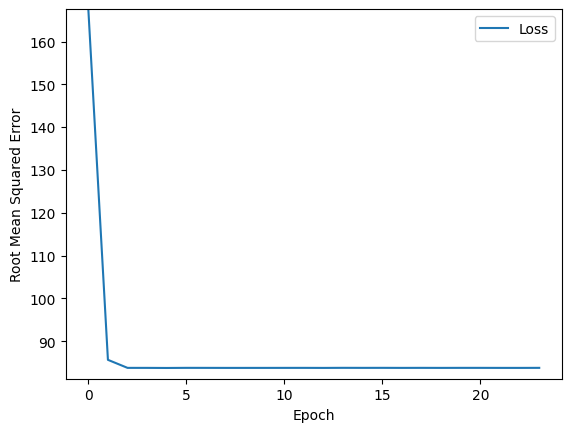

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
    2     53             135
    4     92             214
    3     69             156
    2     62             133
    3     80             155
    2    295             149
   10    500             461
    5    342             262
    2    118             148
    4    128             223
    8    187             400
    3     80             164
    3    112             181
    4     95             223
    2     69             145


In [15]:
#@title Usando o recurso indicado pela matriz de correlação
my_feature = "median_income"

# Tune the hyperparameters.
learning_rate = 0.06
epochs = 24
batch_size = 30

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, mae = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

plot_the_loss_curve(epochs, mae)
predict_house_values(15, my_feature, my_label)